In [1]:
import os
import numpy as np
import pickle
import sys
import random  # 添加Python的random模块
sys.path.append("E:/Qin/wrs")
import wrs.basis.robot_math as rm
import wrs.basis.constant as ct
import wrs.modeling.collision_model as mcm
import wrs.visualization.panda.world as wd
import wrs.modeling.geometric_model as mgm
from wrs.HuGroup_Qin.robot_sim.nova2_wrsv3gripper_regrasp_env import nova2_gripper_v3
import wrs.robot_sim.end_effectors.grippers.wrs_gripper.wrs_gripper_v3 as wrs_gripper_v3
from wrs.grasping.reasoner import GraspReasoner
from wrs.manipulation.placement.flatsurface import FSReferencePoses
from tqdm import tqdm
from scipy.stats import qmc  # 添加到文件开头的import部分
import argparse
import torch  
import torch.nn as nn
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

BASE_PATH = r"E:\Qin\wrs\wrs\HuGroup_Qin\Shared_grasp_project\grasps\Bottle"
GRASP_DATA_PREFIX = "bottle_grasp"
SAVE_PREFIX = "SharedGraspNetwork_bottle_experiment_data"

class GraspEnergyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dims=None, num_layers=3, dropout_rate=0.1):
        super().__init__()
        if hidden_dims is None:
            hidden_dims = [256, 256, 256]
        
        # 确保hidden_dims是列表且长度等于num_layers
        if len(hidden_dims) != num_layers:
            hidden_dims = [hidden_dims[0]] * num_layers
        
        # 构建MLP层
        layers = []
        
        # 输入层
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.SELU())
        layers.append(nn.Dropout(dropout_rate))
        
        # 隐藏层
        for i in range(1, num_layers):
            layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            layers.append(nn.SELU())
            layers.append(nn.Dropout(dropout_rate))
        
        # 输出层
        layers.append(nn.Linear(hidden_dims[-1], 1))
        
        # 创建模型
        self.model = nn.Sequential(*layers)
        
        # 初始化权重
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # SELU激活函数推荐的初始化方法
                nn.init.kaiming_normal_(m.weight, nonlinearity='linear')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.model(x)


def grasp_load(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data


def robot_env_setup():
    # robot configuration
    robot = nova2_gripper_v3(enable_cc=True)
    init_jnv = np.array([-90, -18.1839, 136.3675, -28.1078, -90.09, -350.7043]) * np.pi / 180
    robot.goto_given_conf(jnt_values=init_jnv)
    # robot.gen_meshmodel(alpha=1, toggle_tcp_frame=True, toggle_jnt_frames=True).attach_to(base)
    return robot


def obj_setup(name, pos, rotmat, rgb=None, alpha=None):
    # we only consider SE(2) DOF for the object
    obj_cmodel = mcm.CollisionModel(name=name, rgb=rgb, alpha=alpha,
                initor=r"E:\Qin\wrs\wrs\HuGroup_Qin\objects\meshes\bottle.stl")
    obj_cmodel.pos = pos
    obj_cmodel.rotmat = rotmat
    # obj_cmodel.show_local_frame()
    # obj_cmodel.attach_to(base)
    return obj_cmodel


def get_file_paths(grasp_id):
    """根据grasp_id生成对应的文件路径"""
    grasp_data_path = os.path.join(BASE_PATH, f"{GRASP_DATA_PREFIX}_{grasp_id}.pickle")
    save_path = os.path.join(BASE_PATH, f"{SAVE_PREFIX}_{grasp_id}.pickle")
    return grasp_data_path, save_path

# Function to find common IDs and remove duplicates
def find_common_id(ref_graspid, given_graspid):
    if not given_graspid or not ref_graspid:
        return None
    common_id = set(ref_graspid) & set(given_graspid)
    return list(common_id) if common_id else None


def parse_args():
    parser = argparse.ArgumentParser(description='共享抓取数据收集')
    parser.add_argument('--grasp_ids', type=list, default=[922],
                        help='要处理的抓取ID列表')
    parser.add_argument('--total_iterations', type=int, default=int(300),
                        help='总迭代次数')
    parser.add_argument('--pre_num', type=int, default=int(100),
                        help='预采样次数')
    parser.add_argument('--save_batch_size', type=int, default=1000,
                        help='每批保存的数据大小')
    parser.add_argument('--seed', type=int, default=1,
                        help='随机种子')
    
    parser.add_argument('--input_dim', type=int, default=19,
                        help='输入维度')
    parser.add_argument('--hidden_dims', type=list, default=[512, 512, 512],
                        help='隐藏层维度')
    parser.add_argument('--num_layers', type=int, default=3,
                        help='层数')
    parser.add_argument('--dropout_rate', type=float, default=0.1,
                        help='dropout率')
    parser.add_argument('--model_init_path', type=str, default=r'E:\Qin\wrs\wrs\HuGroup_Qin\Shared_grasp_project\model\feasible_best_model\best_model_grasp_ebm_SharedGraspNetwork_bottle_experiment_data_57_h3_b2048_lr0.001_t0.5_r75000_s0.7_q1_sl1_grobot_table_stinit.pth',
                        help='初始状态模型路径')
    parser.add_argument('--model_goal_path', type=str, default=r'E:\Qin\wrs\wrs\HuGroup_Qin\Shared_grasp_project\model\feasible_best_model\best_model_grasp_ebm_SharedGraspNetwork_bottle_experiment_data_57_h3_b2048_lr0.001_t0.5_r75000_s0.7_q1_sl1_grobot_table_stinit.pth',
                        help='目标状态模型路径')

    parser.add_argument('--f', help=argparse.SUPPRESS) 
    return parser.parse_args()



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import time
import pandas as pd
from scipy.spatial.transform import Rotation as R
base = wd.World(cam_pos=[2, 2, 2], lookat_pos=[0, 0, .3])
mgm.gen_frame().attach_to(base)

def calculate_precision(predictions, ground_truth):
    """
    计算预测精度
    :param predictions: 模型预测的二进制结果
    :param ground_truth: 真实的二进制标签
    :return: 精度值
    """
    # 预测为正例(1)且实际为正例(1)的数量
    true_positives = sum((predictions == 1) & (ground_truth == 1))
    # 预测为正例(1)的总数
    predicted_positives = sum(predictions == 1)
    
    # 避免除以零
    if predicted_positives == 0:
        return 0.0
    
    # 计算精度: TP / (TP + FP)
    precision = true_positives / predicted_positives
    return precision

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
if __name__ == '__main__':


    args = parse_args()
    
    # 设置所有随机种子以确保可重复性
    SEED = args.seed
    random.seed(SEED)  # Python的random模块
    np.random.seed(SEED)  # NumPy

    # 如果使用PyTorch，也设置其随机种子
    if torch.cuda.is_available():
        torch.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    # 更新全局配置
    GRASP_IDS = args.grasp_ids
    TOTAL_ITERATIONS = args.total_iterations
    SAVE_BATCH_SIZE = args.save_batch_size
    
    # 使用LHS采样器
    init_sampler = qmc.LatinHypercube(d=3, seed=SEED)  # 添加种子
    init_samples = init_sampler.random(n=TOTAL_ITERATIONS)

    goal_sampler = qmc.LatinHypercube(d=3, seed=SEED+1)  # 使用不同的种子
    goal_samples = goal_sampler.random(n=TOTAL_ITERATIONS)

    ranges = np.array([
        [-0.45, .45],         # pos_x
        [0.1, .6],            # pos_y
        [0, 2 * np.pi],       # theta
    ])

    init_scaled_samples = qmc.scale(init_samples, ranges[:, 0], ranges[:, 1])
    goal_scaled_samples = qmc.scale(goal_samples, ranges[:, 0], ranges[:, 1])
    
    init_pos_x = np.round(init_scaled_samples[:, 0], decimals=3)
    init_pos_y = np.round(init_scaled_samples[:, 1], decimals=3)
    init_theta = np.round(init_scaled_samples[:, 2], decimals=2)

    goal_pos_x = np.round(goal_scaled_samples[:, 0], decimals=3)
    goal_pos_y = np.round(goal_scaled_samples[:, 1], decimals=3)
    goal_theta = np.round(goal_scaled_samples[:, 2], decimals=2)

    # world configuration
    robot = robot_env_setup()
    gripper = wrs_gripper_v3.WRSGripper3()
    collect_data = []

    # object configuration
    obj_cmodel = mcm.CollisionModel(initor=r"E:\Qin\wrs\wrs\HuGroup_Qin\objects\meshes\bottle.stl")
    obj_init_pos = np.array([-0.424  ,0.156  ,0.   ])
    obj_init_rotmat = rm.rotmat_from_euler(0, 0, 0)
    obj_goal_pos = obj_init_pos.copy()
    obj_goal_rotmat = obj_init_rotmat.copy()
    obj_cmodel_copy = obj_cmodel.copy()

    # 生成所有可能的组合
    fs_reference_poses = FSReferencePoses(obj_cmodel=obj_cmodel)
    all_combinations = np.array(np.meshgrid(
        np.arange(len(fs_reference_poses)),  # init姿态的所有可能（0-4）
        np.arange(len(fs_reference_poses))   # goal姿态的所有可能（0-4）
    )).T.reshape(-1, 2)  # 形状为 (25, 2)
    repeats = TOTAL_ITERATIONS // len(all_combinations) + 1
    repeated_combinations = np.tile(all_combinations, (repeats, 1))
    np.random.shuffle(repeated_combinations)
    init_stable_random_indices = repeated_combinations[:TOTAL_ITERATIONS, 0]
    goal_stable_random_indices = repeated_combinations[:TOTAL_ITERATIONS, 1]

    # onehot编码
    obj_encoder = OneHotEncoder(sparse_output=False)
    obj_encoder.fit(np.array([0, 1, 2, 3, 4]).reshape(-1, 1))
    

    # 标准模式：使用两个模型
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    models = {}
    thresholds_dict = {}
    models['init'] = GraspEnergyNetwork(input_dim=args.input_dim, hidden_dims=args.hidden_dims,
                                        num_layers=args.num_layers, dropout_rate=args.dropout_rate)
    models['goal'] = GraspEnergyNetwork(input_dim=args.input_dim, hidden_dims=args.hidden_dims,
                                        num_layers=args.num_layers, dropout_rate=args.dropout_rate)
    checkpoint_init = torch.load(args.model_init_path, map_location=device)
    models['init'].load_state_dict(checkpoint_init['model_state_dict'])
    models['init'] = models['init'].to(device).float()
    checkpoint_goal = torch.load(args.model_goal_path, map_location=device)
    models['goal'].load_state_dict(checkpoint_goal['model_state_dict'])
    models['goal'] = models['goal'].to(device).float()
    thresholds_dict['init'] = checkpoint_init.get('optimal_threshold', -5.0)
    thresholds_dict['goal'] = checkpoint_goal.get('optimal_threshold', -5.0)
    print(f"\n使用标准模式（两个模型）进行评估")
    print(f"初始状态模型: {os.path.basename(args.model_init_path)}, 阈值: {thresholds_dict['init']:.3f}")
    print(f"目标状态模型: {os.path.basename(args.model_goal_path)}, 阈值: {thresholds_dict['goal']:.3f}")

    # 初始化存储执行时间的字典，每个grasp_id对应一个列表
    nn_execution_times = {grasp_id: [] for grasp_id in GRASP_IDS}
    analysis_execution_times = {grasp_id: [] for grasp_id in GRASP_IDS}
    
    # 初始化存储预测结果和真实标签的字典
    all_predictions = {grasp_id: [] for grasp_id in GRASP_IDS}
    all_pred_sum = {grasp_id: [] for grasp_id in GRASP_IDS}
    all_ground_truths = {grasp_id: [] for grasp_id in GRASP_IDS}
    all_energies = {grasp_id: [] for grasp_id in GRASP_IDS}  # 存储能量值

    for grasp_id in GRASP_IDS:
        
        grasp_data_path, common_id_save_path = get_file_paths(str(grasp_id))
        object_feasible_grasps = grasp_load(grasp_data_path)

        # 首先收集所有ee_values用于计算最大最小值
        ee_values = np.array([grasp.ee_values for grasp in object_feasible_grasps])
        ee_min = np.min(ee_values)
        ee_max = np.max(ee_values)

        RegraspReasoner = GraspReasoner(robot, object_feasible_grasps)

        # print("collect normalization parameters")
        # # 神经网络预测部分
        # init_features = []
        # goal_features = []
        # for sample_idx in range(args.pre_num):
        #     # 保存原始采样位置
        #     original_init_pos = np.array([init_pos_x[sample_idx], init_pos_y[sample_idx], 0])
        #     original_goal_pos = np.array([goal_pos_x[sample_idx], goal_pos_y[sample_idx], 0])
            
        #     # 设置初始位置和目标位置
        #     obj_init_pos = fs_reference_poses._poses[init_stable_random_indices[sample_idx]][0].copy()
        #     obj_init_rotmat = fs_reference_poses._poses[init_stable_random_indices[sample_idx]][1].copy()
        #     obj_init_pos[0:2] = original_init_pos[0:2]  # 只覆盖x和y坐标
        #     obj_init_rotmat = rm.rotmat_from_euler(0, 0, init_theta[sample_idx]) @ obj_init_rotmat

        #     obj_goal_pos = fs_reference_poses._poses[goal_stable_random_indices[sample_idx]][0].copy()
        #     obj_goal_rotmat = fs_reference_poses._poses[goal_stable_random_indices[sample_idx]][1].copy()
        #     obj_goal_pos[0:2] = original_goal_pos[0:2]  # 只覆盖x和y坐标
        #     obj_goal_rotmat = rm.rotmat_from_euler(0, 0, goal_theta[sample_idx]) @ obj_goal_rotmat

        #     # 保存用于计算可行抓取的位置深拷贝
        #     init_pos_for_feasible = obj_init_pos
        #     init_rotmat_for_feasible = obj_init_rotmat

        #     goal_pos_for_feasible = obj_goal_pos
        #     goal_rotmat_for_feasible = obj_goal_rotmat

        #     for index, grasp_pose in enumerate(object_feasible_grasps):
        #         init_features.append(np.concatenate([init_pos_for_feasible, R.from_matrix(init_rotmat_for_feasible).as_quat(), 
        #                                                 obj_encoder.transform([[init_stable_random_indices[sample_idx]]]).copy()[0],
        #                                                 grasp_pose.ac_pos, R.from_matrix(grasp_pose.ac_rotmat).as_quat()]))
                
        #         goal_features.append(np.concatenate([goal_pos_for_feasible, R.from_matrix(goal_rotmat_for_feasible).as_quat(), 
        #                                                 obj_encoder.transform([[goal_stable_random_indices[sample_idx]]]).copy()[0],
        #                                                 grasp_pose.ac_pos, R.from_matrix(grasp_pose.ac_rotmat).as_quat()]))
                
        # init_features = torch.from_numpy(np.array(init_features).astype(np.float32)).to(device)  
        # goal_features = torch.from_numpy(np.array(goal_features).astype(np.float32)).to(device)

        # # 模型推理
        # with torch.no_grad(): 
        #     init_energies = models['init'](init_features).cpu().numpy()
        #     goal_energies = models['goal'](goal_features).cpu().numpy()

        # init_energy_mean = np.mean(init_energies)
        # init_energy_std = np.std(init_energies)

        # goal_energy_mean = np.mean(goal_energies)
        # goal_energy_std = np.std(goal_energies)

        # print(f"init_energy_mean: {init_energy_mean}, init_energy_std: {init_energy_std}")
        # print(f"goal_energy_mean: {goal_energy_mean}, goal_energy_std: {goal_energy_std}")
        # print("collect normalization parameters done")

        with tqdm(total=TOTAL_ITERATIONS, desc=f"Processing grasp_id {grasp_id}") as pbar:
            for sample_idx in range(TOTAL_ITERATIONS):
                # 保存原始采样位置
                original_init_pos = np.array([init_pos_x[sample_idx], init_pos_y[sample_idx], 0])
                original_goal_pos = np.array([goal_pos_x[sample_idx], goal_pos_y[sample_idx], 0])
                
                # 设置初始位置和目标位置
                obj_init_pos = fs_reference_poses._poses[init_stable_random_indices[sample_idx]][0].copy()
                obj_init_rotmat = fs_reference_poses._poses[init_stable_random_indices[sample_idx]][1].copy()
                obj_init_pos[0:2] = original_init_pos[0:2]  # 只覆盖x和y坐标
                obj_init_rotmat = rm.rotmat_from_euler(0, 0, init_theta[sample_idx]) @ obj_init_rotmat

                obj_goal_pos = fs_reference_poses._poses[goal_stable_random_indices[sample_idx]][0].copy()
                obj_goal_rotmat = fs_reference_poses._poses[goal_stable_random_indices[sample_idx]][1].copy()
                obj_goal_pos[0:2] = original_goal_pos[0:2]  # 只覆盖x和y坐标
                obj_goal_rotmat = rm.rotmat_from_euler(0, 0, goal_theta[sample_idx]) @ obj_goal_rotmat

                # 保存用于计算可行抓取的位置深拷贝
                init_pos_for_feasible = obj_init_pos
                init_rotmat_for_feasible = obj_init_rotmat
                goal_pos_for_feasible = obj_goal_pos
                goal_rotmat_for_feasible = obj_goal_rotmat

                # 在init_pos_for_feasible, init_rotmat_for_feasible处计算可行抓取
                # 计算可行抓取 - robot_table_obj
                init_obj = obj_setup(name="init_obj", pos=init_pos_for_feasible, rotmat=init_rotmat_for_feasible, alpha=0.3)

                # 获取真实可行抓取
                start_time = time.time()
                analysis_init_available_gids_robot_table, _, _ = RegraspReasoner.find_feasible_gids(
                    goal_pose=[init_pos_for_feasible, init_rotmat_for_feasible],
                    obstacle_list=[init_obj],
                    toggle_dbg=False
                )

                analysis_goal_available_gids_robot_table, _, _ = RegraspReasoner.find_feasible_gids(
                    goal_pose=[goal_pos_for_feasible, goal_rotmat_for_feasible],
                    obstacle_list=[init_obj],
                    toggle_dbg=False
                )

                common_id = find_common_id(analysis_init_available_gids_robot_table, analysis_goal_available_gids_robot_table)
                end_time = time.time()
                execution_time = end_time - start_time
                analysis_execution_times[grasp_id].append(execution_time)

                # 创建真实标签
                gt_feasible_grasp_ids = np.zeros(len(object_feasible_grasps))
                if common_id is not None:
                    gt_feasible_grasp_ids[list(set(common_id))] = 1
                
                # 存储真实标签
                all_ground_truths[grasp_id].append(gt_feasible_grasp_ids)

                # 开始测量神经网络预测时间
                start_time = time.time()
                
                # 神经网络预测部分
                init_features = []
                goal_features = []
                for index, grasp_pose in enumerate(object_feasible_grasps):
                    init_features.append(np.concatenate([init_pos_for_feasible, R.from_matrix(init_rotmat_for_feasible).as_quat(), 
                                                         obj_encoder.transform([[init_stable_random_indices[sample_idx]]]).copy()[0],
                                                         grasp_pose.ac_pos, R.from_matrix(grasp_pose.ac_rotmat).as_quat()
                                                         ]))
                    
                    goal_features.append(np.concatenate([goal_pos_for_feasible, R.from_matrix(goal_rotmat_for_feasible).as_quat(), 
                                                         obj_encoder.transform([[goal_stable_random_indices[sample_idx]]]).copy()[0],
                                                         grasp_pose.ac_pos, R.from_matrix(grasp_pose.ac_rotmat).as_quat()
                                                         ]))
                
                # 将特征转换为PyTorch张量
                init_features = torch.from_numpy(np.array(init_features).astype(np.float32)).to(device)  
                goal_features = torch.from_numpy(np.array(goal_features).astype(np.float32)).to(device)
                input_features = torch.cat([init_features, goal_features], dim=0)  # 形状为 (2N, 15)

                # 模型推理
                with torch.no_grad():  # 不需要梯度计算
                    energies = models['init'](input_features).cpu().numpy() # 形状为 (2N, 1)
                init_energies = energies[:len(init_features)]
                goal_energies = energies[len(init_features):]
                               
                # 计算组合能量
                # com_energies = init_energies + goal_energies
                # pred_sum = (com_energies < thresholds_dict['init']).astype(np.int32)
                # pred_sum = pred_sum.squeeze()

                # pred_sum = (com_energies < thresholds_dict['init'] + thresholds_dict['goal']).astype(np.int32)
                init_binary = (init_energies < thresholds_dict['init']).astype(np.int32)
                goal_binary = (goal_energies < thresholds_dict['goal']).astype(np.int32)
                pred = np.minimum(init_binary, goal_binary)
                pred = pred.squeeze()
 

                # 测量执行时间结束
                end_time = time.time()
                execution_time = end_time - start_time
                nn_execution_times[grasp_id].append(execution_time)


                # 存储预测结果和能量
                all_predictions[grasp_id].append(pred)
                # all_pred_sum[grasp_id].append(pred_sum)
                # all_energies[grasp_id].append(com_energies.squeeze())

                init_obj.detach()
                del init_obj

                # 更新进度条
                pbar.update(1)
        
        del RegraspReasoner

    # 在运行完所有迭代后统一计算精度
    precision_rates = {}
    recall_rates = {}
    f1_scores = {}
    # precision_sums = {}
    # recall_sums = {}
    # f1_sums = {}
    # positive_counts = {}

    for grasp_id in GRASP_IDS:
        # 合并所有迭代的预测和真实标签
        all_preds = np.concatenate(all_predictions[grasp_id])
        # all_pred_sums = np.concatenate(all_pred_sum[grasp_id])  
        all_truths = np.concatenate(all_ground_truths[grasp_id])
        all_energy_values = np.concatenate(all_energies[grasp_id])
        
        # 计算总体精度
   
        precision = precision_score(all_truths, all_preds, average='binary')
        recall = recall_score(all_truths, all_preds, average='binary')
        f1 = f1_score(all_truths, all_preds, average='binary')

        # precision_sum = precision_score(all_truths, all_pred_sums, average='binary')
        # recall_sum = recall_score(all_truths, all_pred_sums, average='binary')
        # f1_sum = f1_score(all_truths, all_pred_sums, average='binary')
 
        precision_rates[grasp_id] = precision
        recall_rates[grasp_id] = recall
        f1_scores[grasp_id] = f1

        # precision_sums[grasp_id] = precision_sum
        # recall_sums[grasp_id] = recall_sum
        # f1_sums[grasp_id] = f1_sum
        
        # # 统计预测为正的样本数量
        # positive_count = np.sum(all_preds)
        # positive_counts[grasp_id] = positive_count
        
    print("precision_rates: ", precision_rates)
    print("recall_rates: ", recall_rates)
    print("f1_scores: ", f1_scores)
    
    # print("precision_sums: ", precision_sums)
    # print("recall_sums: ", recall_sums)
    # print("f1_sums: ", f1_sums)
    # for grasp_id in GRASP_IDS:
    #     # 合并所有迭代的预测和真实标签
    #     all_preds = np.concatenate(all_predictions[grasp_id])
    #     all_truths = np.concatenate(all_ground_truths[grasp_id])
    #     all_energy_values = np.concatenate(all_energies[grasp_id])
        
    #     # 计算总体精度
    #     precision = precision_score(all_truths, all_preds, average='binary')
    #     precision_rates[grasp_id] = precision
        
    #     # 统计预测为正的样本数量
    #     positive_count = np.sum(all_preds)
    #     positive_counts[grasp_id] = positive_count
        




E:\Qin/wrs\wrs\grasping\planning\segmentation.py:64: RuntimeWarning: invalid value encountered in arccos
  angle_array = np.arccos(adj_face_normal_array.dot(adj_face_normal_array.T))



使用标准模式（两个模型）进行评估
初始状态模型: best_model_grasp_ebm_SharedGraspNetwork_bottle_experiment_data_57_h3_b2048_lr0.001_t0.5_r75000_s0.7_q1_sl1_grobot_table_stinit.pth, 阈值: -4.033
目标状态模型: best_model_grasp_ebm_SharedGraspNetwork_bottle_experiment_data_57_h3_b2048_lr0.001_t0.5_r75000_s0.7_q1_sl1_grobot_table_stinit.pth, 阈值: -4.033


Processing grasp_id 922:   1%|▏         | 4/300 [00:10<13:02,  2.64s/it]E:\Qin/wrs\wrs\robot_sim\manipulators\dobot_nova2\nova2.py:144: RuntimeWarning: invalid value encountered in sqrt
  q[index][0] = np.arctan2(m1, n1) - np.arctan2(d4, np.sqrt(k))
E:\Qin/wrs\wrs\robot_sim\manipulators\dobot_nova2\nova2.py:145: RuntimeWarning: invalid value encountered in sqrt
  q[index + 4][0] = np.arctan2(m1, n1) - np.arctan2(d4, -np.sqrt(k))
Processing grasp_id 922:   3%|▎         | 9/300 [00:23<13:14,  2.73s/it]E:\Qin/wrs\wrs\robot_sim\manipulators\dobot_nova2\nova2.py:144: RuntimeWarning: invalid value encountered in sqrt
  q[index][0] = np.arctan2(m1, n1) - np.arctan2(d4, np.sqrt(k))
E:\Qin/wrs\wrs\robot_sim\manipulators\dobot_nova2\nova2.py:145: RuntimeWarning: invalid value encountered in sqrt
  q[index + 4][0] = np.arctan2(m1, n1) - np.arctan2(d4, -np.sqrt(k))
Processing grasp_id 922:   4%|▎         | 11/300 [00:29<13:40,  2.84s/it]E:\Qin/wrs\wrs\robot_sim\manipulators\dobot_nova2\nova2.py:14

ValueError: need at least one array to concatenate

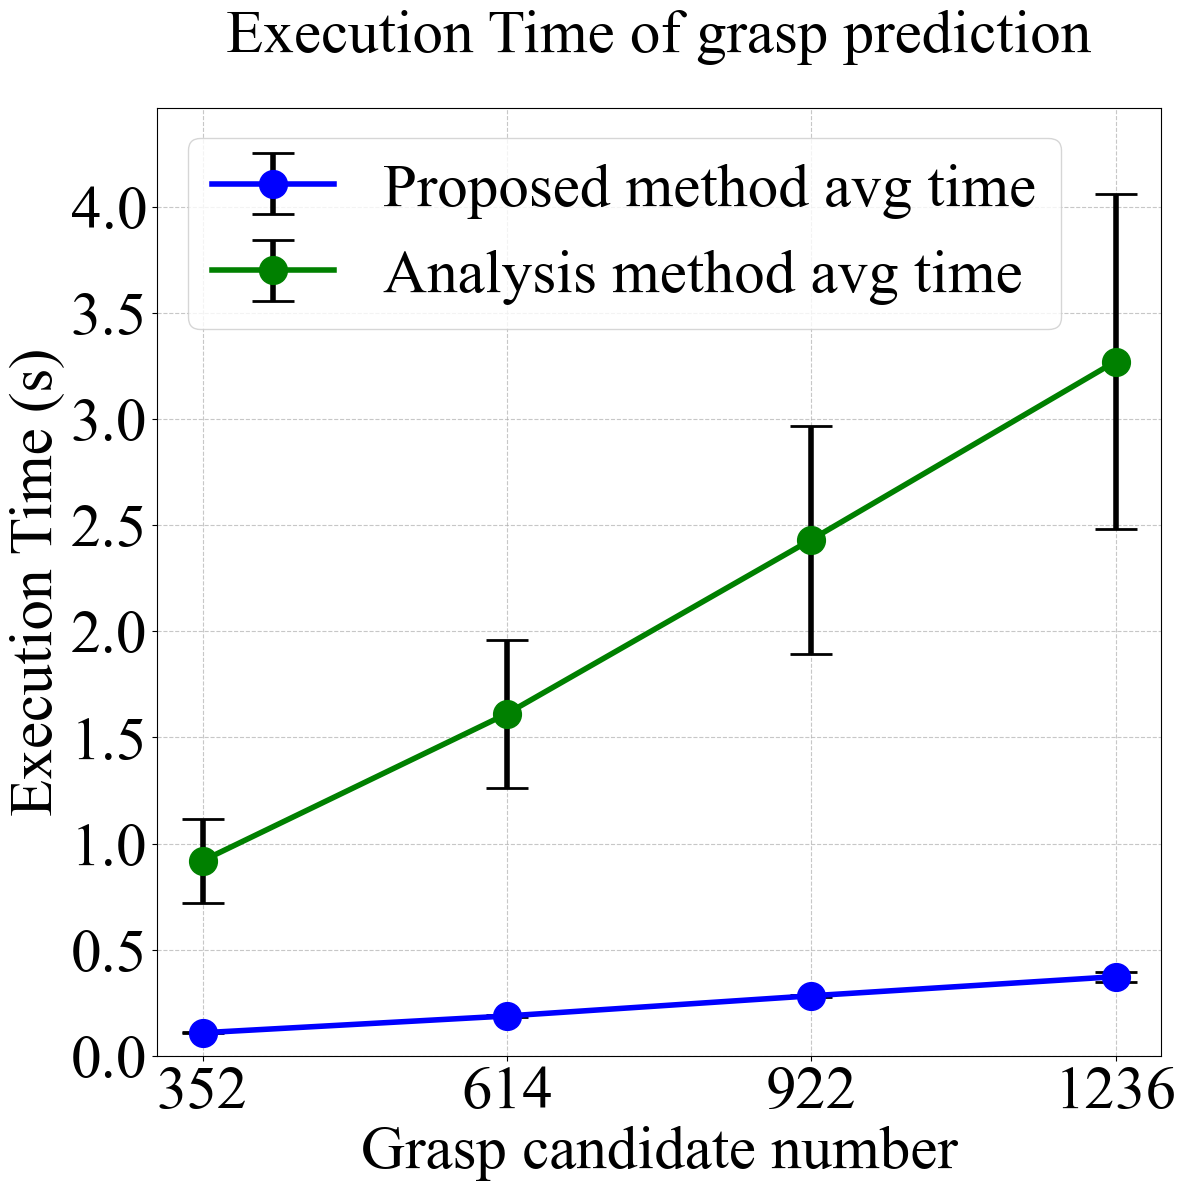

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 设置全局字体为Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  # 数学公式字体也使用类似Times的字体

# 假设数据已经读入为DataFrame，或者从文本创建DataFrame
data = pd.DataFrame([
    [352, 0.10817848920822143, 0.003288045356839847, 0.9189028058052063, 0.19887501315879372, 0.89286, 100],
    [614, 0.18731012964248658, 0.005393053981682793, 1.6116756720542909, 0.3495387922496742, 0.73446, 100],
    [922, 0.28232561016082763, 0.0054878436771774565, 2.431625528335571, 0.5373837701083359, 0.81287, 100],
    [1236, 0.37255263471603395, 0.023931413506415644, 3.2711896591186522, 0.7905740526278463, 0.63014, 100]
], columns=['grasp_id', 'nn_avg_time', 'nn_std_time', 'analysis_avg_time', 'analysis_std_time', 'avg_precision', 'count'])

# 设置图形大小
plt.figure(figsize=(12, 12))

# 获取x轴刻度（Grasp ID）
grasp_ids = data['grasp_id'].astype(str).tolist()

# 绘制神经网络平均时间和误差条
plt.errorbar(grasp_ids, data['nn_avg_time'], yerr=data['nn_std_time'], 
             fmt='-o', ecolor='black', capsize=15, capthick=2, 
             label='Proposed method avg time', color='blue', linewidth=4, markersize=20)

# 绘制分析法平均时间和误差条
plt.errorbar(grasp_ids, data['analysis_avg_time'], yerr=data['analysis_std_time'], 
             fmt='-o', ecolor='black', capsize=15, capthick=2, 
             label='Analysis method avg time', color='green', linewidth=4, markersize=20)

# 添加图例和标签
plt.legend(fontsize=44)
plt.xlabel('Grasp candidate number', fontsize=44)
plt.ylabel('Execution Time (s)', fontsize=44)
plt.xticks(fontsize=44)
plt.yticks(fontsize=44)
plt.title('Execution Time of grasp prediction', fontsize=44, y=1.05)

# 设置网格
plt.grid(True, linestyle='--', alpha=0.7)

# 调整Y轴范围，使图形更美观
y_max = max(data['analysis_avg_time'] + data['analysis_std_time']) * 1.1
plt.ylim(0, y_max)


# 添加图例
plt.tight_layout()

# 保存图片（可选）
plt.savefig('grasp_id_execution_time_comparison.png', dpi=1000, bbox_inches='tight')

# 显示图形
plt.show()

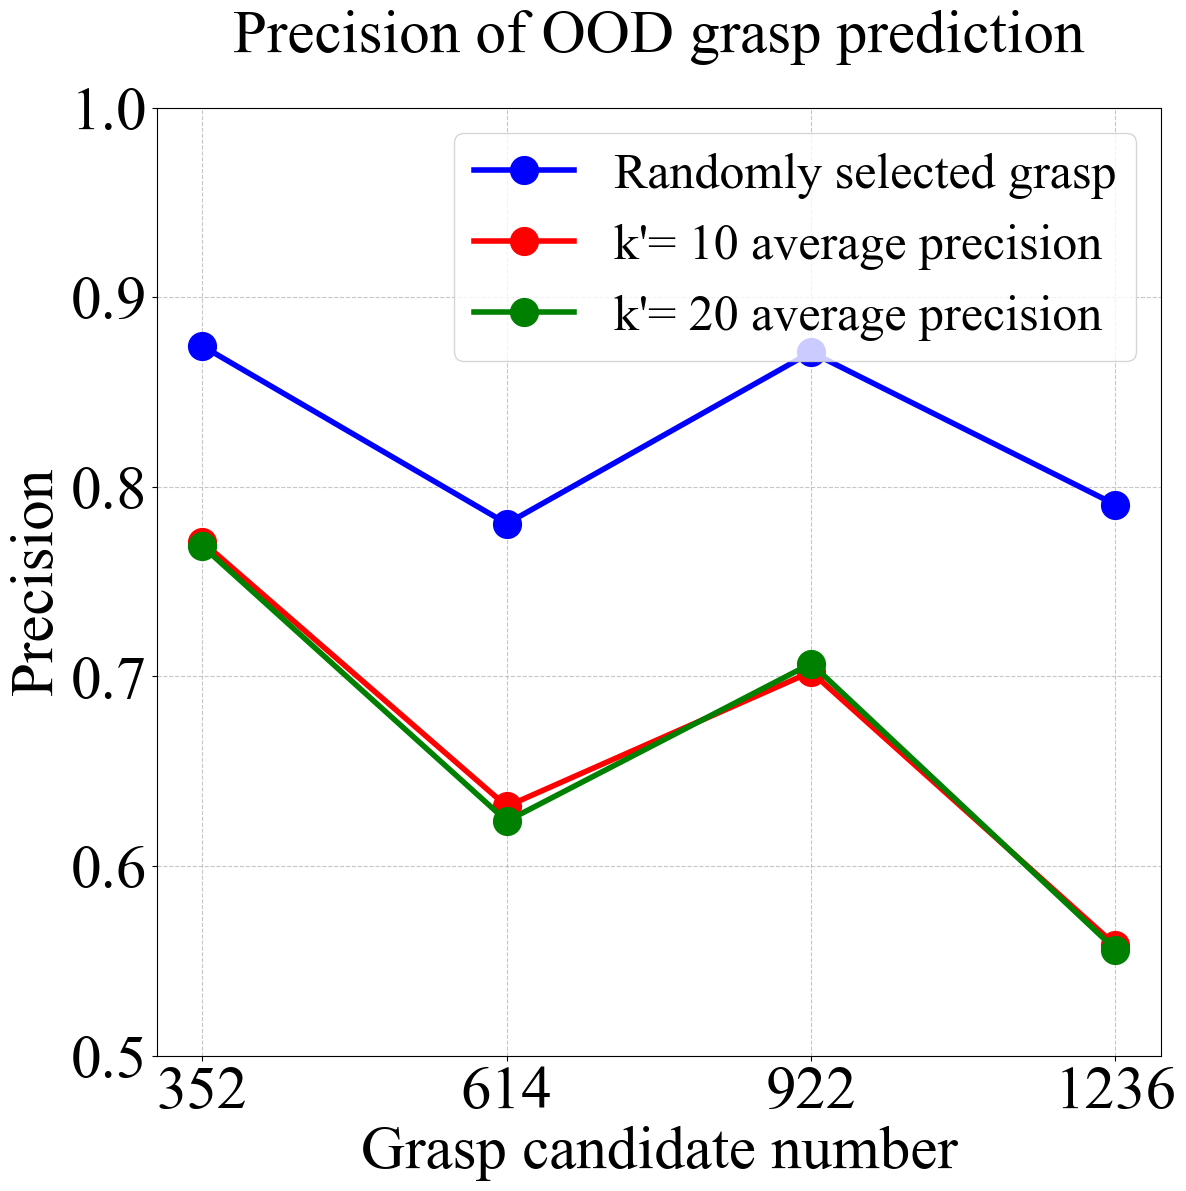

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 设置全局字体为Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  # 数学公式字体也使用类似Times的字体

# 假设数据已经读入为DataFrame，或者从文本创建DataFrame   0.89286
data = pd.DataFrame([
    [352, 0.10817848920822143, 0.003288045356839847, 0.9189028058052063, 0.19887501315879372, 0.8742, 0.777,  0.7710, 0.7687, 300],
    [614, 0.18731012964248658, 0.005393053981682793, 1.6116756720542909, 0.3495387922496742,  0.78059, 0.6265, 0.6315, 0.6237, 300],
    [922, 0.28232561016082763, 0.0054878436771774565, 2.431625528335571, 0.5373837701083359,  0.871,   0.7056, 0.7024, 0.7068, 300],
    [1236, 0.37255263471603395, 0.023931413506415644, 3.2711896591186522, 0, 0.7905740526278463, 0.5763,  0.5583, 0.5560, 300]
], columns=['grasp_id', 'nn_avg_time', 'nn_std_time', 'analysis_avg_time', 'analysis_std_time', 'precision', 'top5_precision',
            'top10_precision', 'top20_precision','count'])

# 设置图形大小
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

# 获取x轴刻度（Grasp ID）
grasp_ids = data['grasp_id'].astype(str).tolist()

# 绘制平均精确率折线图
ax.plot(grasp_ids, data['precision'], 
         '-o', color='blue', linewidth=4, markersize=20,
         label='Randomly selected grasp')
# ax.plot(grasp_ids, data['top5_precision'], 
#          '-o', color='green', linewidth=4, markersize=20,
#          label='k\'= 5 average precision')
ax.plot(grasp_ids, data['top10_precision'], 
         '-o', color='red', linewidth=4, markersize=20,
         label='k\'= 10 average precision')
ax.plot(grasp_ids, data['top20_precision'], 
         '-o', color='green', linewidth=4, markersize=20,
         label='k\'= 20 average precision')

# 添加图例和标签
ax.legend(fontsize=36)
ax.set_xlabel('Grasp candidate number', fontsize=44)
ax.set_ylabel('Precision', fontsize=44)
ax.tick_params(axis='both', labelsize=44)
ax.set_title('Precision of OOD grasp prediction', fontsize=44, y=1.05)

# 设置网格
ax.grid(True, linestyle='--', alpha=0.7)

# 调整Y轴范围，使图形更美观
ax.set_ylim(0.5, 1.0)  # 精确率范围在0.5到1之间

# 增加边框宽度
# for spine in ax.spines.values():
#     spine.set_linewidth(3)

# 添加图例
plt.tight_layout()

# 保存图片（可选）
plt.savefig('grasp_id_precision_comparison.png', dpi=1000, bbox_inches='tight')

# 显示图形
plt.show()